In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import shutil
import projcore as pc
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity


sns.set(style="whitegrid")

In [7]:
source_dir = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    pc.download_kaggle_datasets()
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.csv'):
            full_file_name = os.path.join(source_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, DATA_DIR)
                print(f"Moved: {full_file_name} to {DATA_DIR}")
else:
    print(f"Data directory already exists: {DATA_DIR}")

Data directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\data


In [8]:
def load_data(data_dir=DATA_DIR):
    """Load all datasets."""
    battles_df = pd.read_csv(os.path.join(data_dir, 'BattlesStaging_01012021_WL_tagged.csv'))
    clash_royal_data = pd.read_csv(os.path.join(data_dir, 'clash_royal_data.csv'))
    card_master_list = pd.read_csv(os.path.join(data_dir, 'CardMasterListSeason18_12082020.csv'))
    wincons = pd.read_csv(os.path.join(data_dir, 'Wincons.csv'))
    
    mapping = {
        'battles_df': battles_df,
        'clash_royal_data': clash_royal_data,
        'card_master_list': card_master_list,
        'wincons': wincons
    }
    
    return mapping

In [9]:
# load the actual data
datasets_mapping = load_data()
battles_df = datasets_mapping['battles_df']
clash_royal_data = datasets_mapping['clash_royal_data']
card_master_list = datasets_mapping['card_master_list']
wincons = datasets_mapping['wincons']

In [10]:
battles_df = pc.feature_preprocessing(battles_df, wincons)

In [11]:
winner_decks = battles_df["winner.card_set"]
loser_decks = battles_df["loser.card_set"]

unique_winner_decks = winner_decks.unique()
num_unique_winner_decks = len(unique_winner_decks)
print(f"Number of unique winner decks: {num_unique_winner_decks}")
print("battles_df rows: ", battles_df.shape[0])
print("Ratio of unique winner decks to battles_df rows: ", num_unique_winner_decks / battles_df.shape[0])


Number of unique winner decks: 1292041
battles_df rows:  2823527
Ratio of unique winner decks to battles_df rows:  0.45759824503183427


In [19]:
def deck_to_sparse_vector(deck):
    """Convert a deck into a sparse binary vector."""
    indices = [card_to_index[card] for card in deck]
    vec = np.zeros(len(unique_cards), dtype=np.uint8)
    vec[indices] = 1
    return vec

deck_stats = {}
for deck in winner_decks:
    if deck not in deck_stats:
        deck_stats[deck] = {"wins": 0, "appearances": 0}
    deck_stats[deck]["wins"] += 1
    deck_stats[deck]["appearances"] += 1

for deck in loser_decks:
    if deck not in deck_stats:
        continue
    deck_stats[deck]["appearances"] += 1

deck_data = [
    {"Deck": deck, "Win Rate": stats["wins"] / stats["appearances"], "Appearances": stats["appearances"]}
    for deck, stats in deck_stats.items()
]

deck_data = [
    {"Deck": deck, "Win Rate": stats["wins"] / stats["appearances"], "Appearances": stats["appearances"]}
    for deck, stats in deck_stats.items()
]
deck_df = pd.DataFrame(deck_data)
deck_df = deck_df.sort_values(by="Appearances", ascending=False)
unique_cards = sorted(set(card for deck in deck_df["Deck"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}

In [20]:
appearance_threshold = 15
winning_deck_threshold = 0.6
winner_df = deck_df[(deck_df["Appearances"] >= appearance_threshold) & (deck_df["Win Rate"] >= winning_deck_threshold)].copy()
loser_df = deck_df[(deck_df["Appearances"] >= appearance_threshold) & (deck_df["Win Rate"] < winning_deck_threshold)].copy()
scaler = MinMaxScaler()
winner_df.loc[:, "win_rate_scaled"] = scaler.fit_transform(winner_df["Win Rate"].values.reshape(-1, 1))
winner_df.loc[:, "appearance_scaled"] = scaler.fit_transform(winner_df["Appearances"].values.reshape(-1, 1))

deck_df = winner_df
deck_df.drop(columns=["Win Rate", "Appearances"], inplace=True)
deck_vectors = np.array([deck_to_sparse_vector(deck) for deck in deck_df["Deck"]])
deck_vectors_sparse = csr_matrix(deck_vectors)
deck_vectors_dense = deck_vectors_sparse.toarray()

deck_df

,Deck,win_rate_scaled,appearance_scaled
37618,"(26000016, 26000026, 26000027, 26000041, 26000...",0.079341,1.000000
44680,"(26000006, 26000012, 26000020, 26000023, 26000...",0.067797,0.507837
82597,"(26000012, 26000014, 26000024, 26000026, 26000...",0.000000,0.485893
44882,"(26000009, 26000015, 26000018, 26000039, 26000...",0.023669,0.482759
2310,"(26000022, 26000032, 26000041, 26000049, 26000...",0.006024,0.473354
...,...,...,...
207156,"(26000012, 26000021, 26000022, 26000026, 26000...",0.333333,0.000000
344089,"(26000009, 26000023, 26000035, 26000063, 26000...",0.000000,0.000000
527413,"(26000001, 26000004, 26000006, 26000008, 26000...",0.333333,0.000000
64004,"(26000018, 26000041, 26000053, 26000056, 26000...",0.333333,0.000000


In [ ]:
# pairwise_dist = pairwise_distances(deck_vectors_dense, metric="hamming")
pairwise_dist = squareform(pdist(deck_vectors_dense, metric="hamming"))

In [22]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds = mds.fit_transform(pairwise_dist)

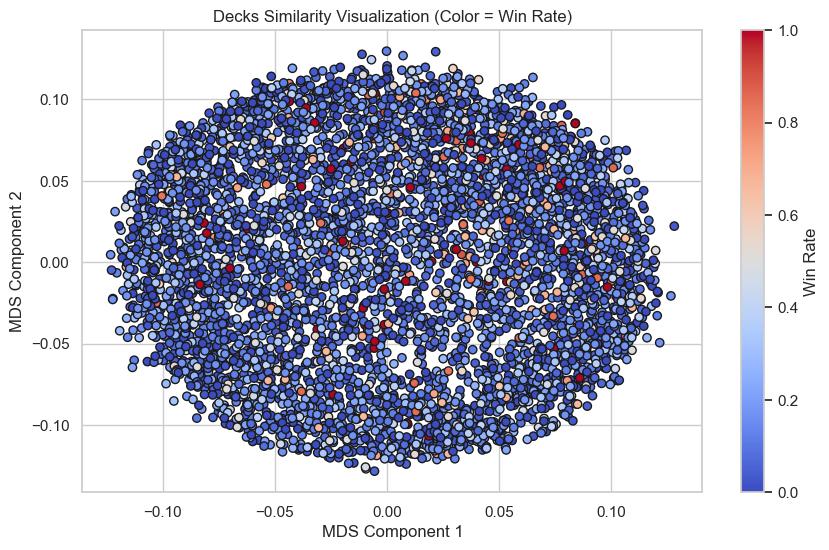

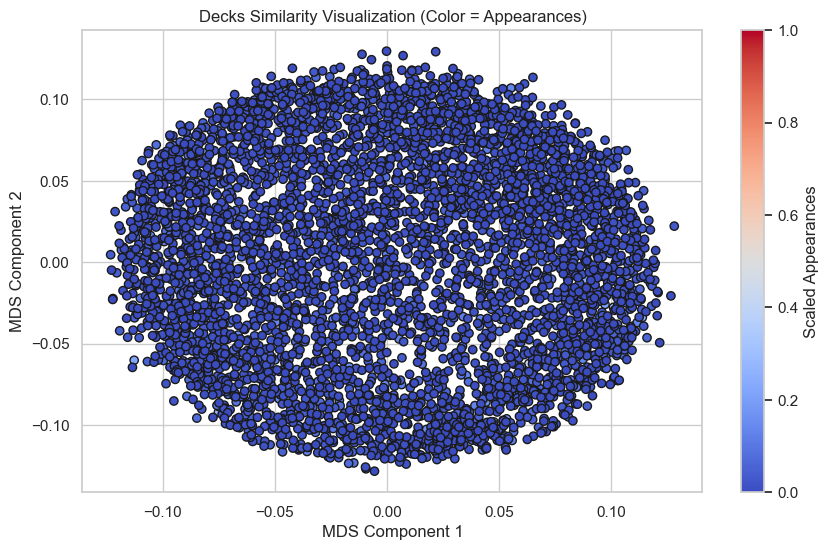

In [33]:
# color represents win_rate
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                 c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Win Rate")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")
plt.title("Decks Similarity Visualization (Color = Win Rate)")
plt.savefig("deck_similarity_plot_mds.png", dpi=300)
plt.show()

# color represents appearances
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                 c=deck_df["appearance_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Scaled Appearances")
plt.xlabel("MDS Component 1")
plt.ylabel("MDS Component 2")
plt.title("Decks Similarity Visualization (Color = Appearances)")
plt.savefig("deck_similarity_plot_appearances.png", dpi=300)
plt.show()

# Initial Notes:
1. there doesn't seem to be a correlation between the plot for appearances and the plot for win rate
2. appearances seem to be uniform more or less as most points are colored the same
3. win rate is not as uniform as appearances because we can see more diversity.

In [34]:

tsne = TSNE(n_components=2, metric="hamming", random_state=42, perplexity=30, n_jobs=-1)
deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)


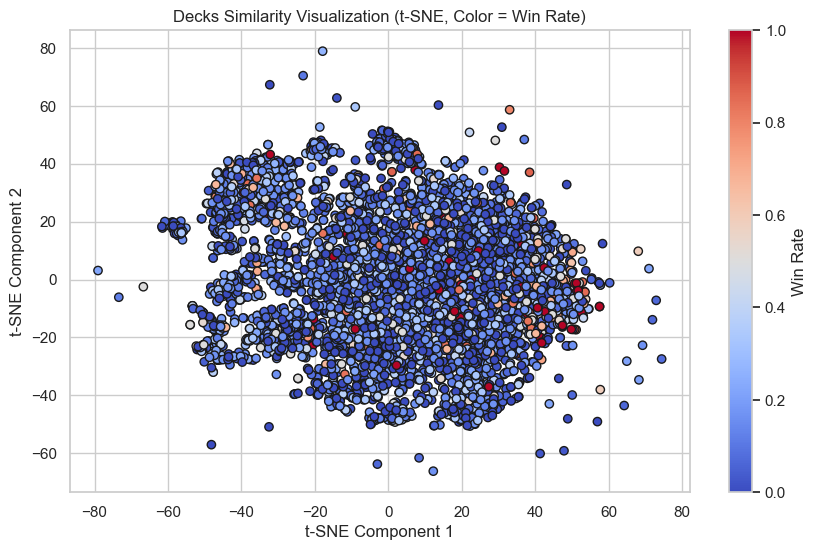

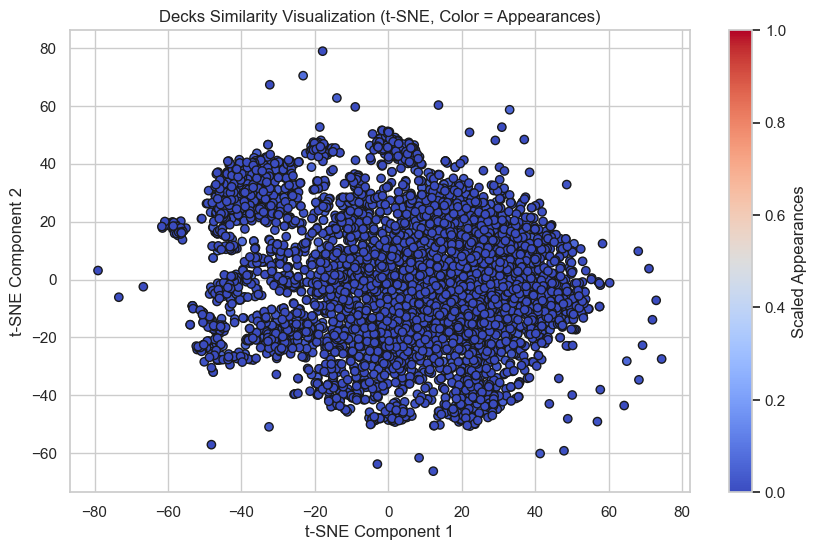

In [ ]:
# color represents win_rate
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                 c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Win Rate")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Decks Similarity Visualization (t-SNE, Color = Win Rate)")
plt.savefig("deck_similarity_plot_tsne_win_rate.png", dpi=300)
plt.show()

# color represents appearances
plt.figure(figsize=(10, 6))
sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                 c=deck_df["appearance_scaled"], cmap="coolwarm", edgecolors="k")
cbar = plt.colorbar(sc)
cbar.set_label("Scaled Appearances")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Decks Similarity Visualization (t-SNE, Color = Appearances)")
plt.savefig("deck_similarity_plot_tsne_appearances.png", dpi=300)
plt.show()


# Initial thoughts:
1. tsne outcomes seems to be more cramped together than MDS
2. Even though the win rate is still distributed ~uniformly, I can distinguish that at the edges there seems to be clearer red
3. still similar to previously the appearances are still almost uniform